# 以CQI美國咖啡品質協會的杯測指標做咖啡豆品質預測

## 【前導】
> * 咖啡是十分常見的飲料，對於很多上班族來說更是每天工作的好夥伴  
> * SCA與CQI是兩大世界最知名的咖啡鑑定組織，訂定出嚴格的咖啡品質分級和嚴謹的咖啡師鑑定考試  
> * 本文以2018年1月CQI所發布的咖啡豆資料做進一部探討
> * 資料來源：[data_github](https://github.com/jldbc/coffee-quality-database/tree/master/data)、[CQI美國咖啡品質協會](https://www.coffeeinstitute.org/)

## 【研究想法】
> 咖啡豆主要分為阿拉比卡豆(Arabica)與羅布斯塔(Robusta)，一般而言阿拉比卡豆的品質與風味比起羅布斯塔更佳優越
> CQI將這兩種豆種的資料分開發布，但本次研究決定將豆種特徵納入模型，故合併兩種豆種資料做進一部探討

## 【研究方法】
1. [讀入資料](##讀入資料)
2. 先清理資料表，再合併

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

## 讀入資料
咖啡豆主要分為阿拉比卡與羅布斯塔，我們讀取兩種表並觀察欄位標題是否不同

In [2]:
ara_df = pd.read_csv(r'D:\DataMining\week02\201801arabica.txt') #阿拉比卡
rou_df = pd.read_csv(r'D:\DataMining\week02\201801robusta.txt') #羅布斯塔
ara_df = ara_df.drop(ara_df.columns[0],axis=1) #第一欄位只是序號，直接刪除
rou_df = rou_df.drop(rou_df.columns[0],axis=1) #第一欄位只是序號，直接刪除
display(ara_df.head(3),rou_df.head(3))

,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,Region,...,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,...,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
1,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,...,Green,1,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
2,Arabica,grounds for health admin,Guatemala,"san marcos barrancas ""san cristobal cuch",NaN,NaN,NaN,NaN,1600 - 1800 m,NaN,...,NaN,0,"May 31st, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1600.0,1800.0,1700.0


,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,Region,...,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,Robusta,ankole coffee producers coop,Uganda,kyangundu cooperative society,NaN,ankole coffee producers,0,ankole coffee producers coop,1488,sheema south western,...,Green,2,"June 26th, 2015",Uganda Coffee Development Authority,e36d0270932c3b657e96b7b0278dfd85dc0fe743,03077a1c6bac60e6f514691634a7f6eb5c85aae8,m,1488.0,1488.0,1488.0
1,Robusta,nishant gurjer,India,sethuraman estate kaapi royale,25,sethuraman estate,14/1148/2017/21,kaapi royale,3170,chikmagalur karnataka indua,...,NaN,2,"October 31st, 2018",Specialty Coffee Association,ff7c18ad303d4b603ac3f8cff7e611ffc735e720,352d0cf7f3e9be14dad7df644ad65efc27605ae2,m,3170.0,3170.0,3170.0
2,Robusta,andrew hetzel,India,sethuraman estate,NaN,NaN,0000,sethuraman estate,1000m,chikmagalur,...,Green,0,"April 29th, 2016",Specialty Coffee Association,ff7c18ad303d4b603ac3f8cff7e611ffc735e720,352d0cf7f3e9be14dad7df644ad65efc27605ae2,m,1000.0,1000.0,1000.0


## 清整資料
取用想觀察的欄位，刪除不需要的欄位，調整欄位順序、換成相同標題名，再做合併

In [3]:
ara_df = ara_df[["Owner","Species","Country.of.Origin","Grading.Date","Aroma","Flavor","Acidity","Sweetness","Body","Aftertaste","Balance","Uniformity","Clean.Cup","Cupper.Points","Moisture","Category.One.Defects","Category.Two.Defects","Total.Cup.Points"]] #取用欄位並排序
ara_df = ara_df.rename(columns={'Grading.Date':'Grading','Country.of.Origin':'Country','Category.One.Defects':'C1', 'Category.Two.Defects':'C2','Total.Cup.Points':'TotalCupPoints'}) #重新命名欄位

rou_df = rou_df[["Owner","Species","Country.of.Origin","Grading.Date","Fragrance...Aroma","Flavor","Salt...Acid","Bitter...Sweet","Mouthfeel","Aftertaste","Balance","Uniform.Cup","Clean.Cup","Cupper.Points","Moisture","Category.One.Defects","Category.Two.Defects","Total.Cup.Points"]] #取用欄位並排序
rou_df = rou_df.rename(columns={'Fragrance...Aroma':'Aroma','Salt...Acid':'Acidity','Bitter...Sweet':'Sweetness','Mouthfeel':'Body','Uniform.Cup':'Uniformity','Grading.Date':'Grading','Country.of.Origin':'Country','Category.One.Defects':'C1', 'Category.Two.Defects':'C2','Total.Cup.Points':'TotalCupPoints'}) #重新命名欄位

In [4]:
display(ara_df.describe(),rou_df.describe()) #觀察兩種咖啡品種的敘述統計

,Aroma,Flavor,Acidity,Sweetness,Body,Aftertaste,Balance,Uniformity,Clean.Cup,Cupper.Points,Moisture,C1,C2,TotalCupPoints
count,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.00000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000
mean,7.563806,7.518070,7.533112,9.903272,7.517727,7.397696,7.517506,9.833394,9.83312,7.497864,0.088863,0.426392,3.591915,82.115927
std,0.378666,0.399979,0.381599,0.530832,0.359213,0.405119,0.406316,0.559343,0.77135,0.474610,0.047957,1.832415,5.350371,3.515761
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.420000,7.330000,7.330000,10.000000,7.330000,7.250000,7.330000,10.000000,10.00000,7.250000,0.090000,0.000000,0.000000,81.170000
50%,7.580000,7.580000,7.500000,10.000000,7.500000,7.420000,7.500000,10.000000,10.00000,7.500000,0.110000,0.000000,2.000000,82.500000
75%,7.750000,7.750000,7.750000,10.000000,7.670000,7.580000,7.750000,10.000000,10.00000,7.750000,0.120000,0.000000,4.000000,83.670000
max,8.750000,8.830000,8.750000,10.000000,8.580000,8.670000,8.750000,10.000000,10.00000,10.000000,0.280000,31.000000,55.000000,90.580000


,Aroma,Flavor,Acidity,Sweetness,Body,Aftertaste,Balance,Uniformity,Clean.Cup,Cupper.Points,Moisture,C1,C2,TotalCupPoints
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,7.702500,7.630714,7.657143,7.675714,7.506786,7.559643,7.541786,9.904286,9.928214,7.761429,0.065714,2.964286,1.892857,80.868929
std,0.296156,0.303656,0.261773,0.317063,0.725152,0.342469,0.526076,0.238753,0.211030,0.330507,0.058464,12.357280,2.601129,2.441233
min,6.750000,6.670000,6.830000,6.670000,5.080000,6.500000,5.250000,9.330000,9.330000,6.920000,0.000000,0.000000,0.000000,73.750000
25%,7.580000,7.560000,7.560000,7.580000,7.500000,7.397500,7.500000,10.000000,10.000000,7.580000,0.000000,0.000000,0.000000,80.170000
50%,7.670000,7.710000,7.710000,7.750000,7.670000,7.670000,7.670000,10.000000,10.000000,7.830000,0.100000,0.000000,1.000000,81.500000
75%,7.920000,7.830000,7.830000,7.830000,7.830000,7.770000,7.830000,10.000000,10.000000,7.920000,0.120000,0.000000,2.000000,82.520000
max,8.330000,8.080000,8.000000,8.420000,8.250000,7.920000,8.000000,10.000000,10.000000,8.580000,0.130000,63.000000,9.000000,83.750000


In [5]:
df = pd.concat([ara_df,rou_df], axis = 0, ignore_index=True) #合併並忽略index重新設定
df.shape #總資料筆數
#df.to_csv(r'D:\DataMining\week02\concat.csv',encoding='utf_8_sig', index=False) #存檔

(1339, 18)

# 整理資料表
### 將不需要運算的資料都清除

In [6]:
ddf = df.drop(['Country','Grading'], axis=1) #刪去不須運算的欄位
ddf['Species'] = df['Species'].apply(lambda x: '1' if x == 'Arabica' else '0') #分類轉換成數值
ddf

,Owner,Species,Aroma,Flavor,Acidity,Sweetness,Body,Aftertaste,Balance,Uniformity,Clean.Cup,Cupper.Points,Moisture,C1,C2,TotalCupPoints
0,metad plc,1,8.67,8.83,8.75,10.00,8.50,8.67,8.42,10.00,10.00,8.75,0.12,0,0,90.58
1,metad plc,1,8.75,8.67,8.58,10.00,8.42,8.50,8.42,10.00,10.00,8.58,0.12,0,1,89.92
2,grounds for health admin,1,8.42,8.50,8.42,10.00,8.33,8.42,8.42,10.00,10.00,9.25,0.00,0,0,89.75
3,yidnekachew dabessa,1,8.17,8.58,8.42,10.00,8.50,8.42,8.25,10.00,10.00,8.67,0.11,0,2,89.00
4,metad plc,1,8.25,8.50,8.50,10.00,8.42,8.25,8.33,10.00,10.00,8.58,0.12,0,2,88.83
5,ji-ae ahn,1,8.58,8.42,8.50,10.00,8.25,8.42,8.33,10.00,10.00,8.33,0.11,0,1,88.83
6,hugo valdivia,1,8.42,8.50,8.50,10.00,8.25,8.33,8.25,10.00,10.00,8.50,0.11,0,0,88.75
7,ethiopia commodity exchange,1,8.25,8.33,8.42,9.33,8.33,8.50,8.50,10.00,10.00,9.00,0.03,0,0,88.67
8,ethiopia commodity exchange,1,8.67,8.67,8.42,9.33,8.33,8.58,8.42,9.33,10.00,8.67,0.03,0,0,88.42
9,diamond enterprise plc,1,8.08,8.58,8.50,10.00,7.67,8.50,8.42,10.00,10.00,8.50,0.10,0,4,88.25


In [7]:
ddf.isna().values.any() #是否有空值

True

In [8]:
display(ddf.info(),ddf.isna().sum()) #了解資料型態與空值分布

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 16 columns):
Owner             1332 non-null object
Species           1339 non-null object
Aroma             1339 non-null float64
Flavor            1339 non-null float64
Acidity           1339 non-null float64
Sweetness         1339 non-null float64
Body              1339 non-null float64
Aftertaste        1339 non-null float64
Balance           1339 non-null float64
Uniformity        1339 non-null float64
Clean.Cup         1339 non-null float64
Cupper.Points     1339 non-null float64
Moisture          1339 non-null float64
C1                1339 non-null int64
C2                1339 non-null int64
TotalCupPoints    1339 non-null float64
dtypes: float64(12), int64(2), object(2)
memory usage: 167.5+ KB


None

Owner             7
Species           0
Aroma             0
Flavor            0
Acidity           0
Sweetness         0
Body              0
Aftertaste        0
Balance           0
Uniformity        0
Clean.Cup         0
Cupper.Points     0
Moisture          0
C1                0
C2                0
TotalCupPoints    0
dtype: int64

In [9]:
ddf.fillna('unknown') #只有owner有空值，並不影響後續的運算，直接補上'unknown'
ddf

,Owner,Species,Aroma,Flavor,Acidity,Sweetness,Body,Aftertaste,Balance,Uniformity,Clean.Cup,Cupper.Points,Moisture,C1,C2,TotalCupPoints
0,metad plc,1,8.67,8.83,8.75,10.00,8.50,8.67,8.42,10.00,10.00,8.75,0.12,0,0,90.58
1,metad plc,1,8.75,8.67,8.58,10.00,8.42,8.50,8.42,10.00,10.00,8.58,0.12,0,1,89.92
2,grounds for health admin,1,8.42,8.50,8.42,10.00,8.33,8.42,8.42,10.00,10.00,9.25,0.00,0,0,89.75
3,yidnekachew dabessa,1,8.17,8.58,8.42,10.00,8.50,8.42,8.25,10.00,10.00,8.67,0.11,0,2,89.00
4,metad plc,1,8.25,8.50,8.50,10.00,8.42,8.25,8.33,10.00,10.00,8.58,0.12,0,2,88.83
5,ji-ae ahn,1,8.58,8.42,8.50,10.00,8.25,8.42,8.33,10.00,10.00,8.33,0.11,0,1,88.83
6,hugo valdivia,1,8.42,8.50,8.50,10.00,8.25,8.33,8.25,10.00,10.00,8.50,0.11,0,0,88.75
7,ethiopia commodity exchange,1,8.25,8.33,8.42,9.33,8.33,8.50,8.50,10.00,10.00,9.00,0.03,0,0,88.67
8,ethiopia commodity exchange,1,8.67,8.67,8.42,9.33,8.33,8.58,8.42,9.33,10.00,8.67,0.03,0,0,88.42
9,diamond enterprise plc,1,8.08,8.58,8.50,10.00,7.67,8.50,8.42,10.00,10.00,8.50,0.10,0,4,88.25


In [10]:
ddf['Pass'] = df['TotalCupPoints'].apply(lambda x: '1' if x >=85 else '0') #最終總分通過85分的咖啡為好咖啡
ddf = ddf.sort_values(ascending=False, by=['TotalCupPoints']) #分數由高到低排序
ddf

,Owner,Species,Aroma,Flavor,Acidity,Sweetness,Body,Aftertaste,Balance,Uniformity,Clean.Cup,Cupper.Points,Moisture,C1,C2,TotalCupPoints,Pass
0,metad plc,1,8.67,8.83,8.75,10.00,8.50,8.67,8.42,10.00,10.00,8.75,0.12,0,0,90.58,1
1,metad plc,1,8.75,8.67,8.58,10.00,8.42,8.50,8.42,10.00,10.00,8.58,0.12,0,1,89.92,1
2,grounds for health admin,1,8.42,8.50,8.42,10.00,8.33,8.42,8.42,10.00,10.00,9.25,0.00,0,0,89.75,1
3,yidnekachew dabessa,1,8.17,8.58,8.42,10.00,8.50,8.42,8.25,10.00,10.00,8.67,0.11,0,2,89.00,1
4,metad plc,1,8.25,8.50,8.50,10.00,8.42,8.25,8.33,10.00,10.00,8.58,0.12,0,2,88.83,1
5,ji-ae ahn,1,8.58,8.42,8.50,10.00,8.25,8.42,8.33,10.00,10.00,8.33,0.11,0,1,88.83,1
6,hugo valdivia,1,8.42,8.50,8.50,10.00,8.25,8.33,8.25,10.00,10.00,8.50,0.11,0,0,88.75,1
7,ethiopia commodity exchange,1,8.25,8.33,8.42,9.33,8.33,8.50,8.50,10.00,10.00,9.00,0.03,0,0,88.67,1
8,ethiopia commodity exchange,1,8.67,8.67,8.42,9.33,8.33,8.58,8.42,9.33,10.00,8.67,0.03,0,0,88.42,1
9,diamond enterprise plc,1,8.08,8.58,8.50,10.00,7.67,8.50,8.42,10.00,10.00,8.50,0.10,0,4,88.25,1


# Decesion Tree

In [11]:
x = ddf[["Species","Aroma","Flavor","Acidity","Sweetness","Body","Aftertaste","Balance","Uniformity","Clean.Cup","Cupper.Points","Moisture"]]
y = ddf['Pass']

In [12]:
display(x.head(),y[:3])

,Species,Aroma,Flavor,Acidity,Sweetness,Body,Aftertaste,Balance,Uniformity,Clean.Cup,Cupper.Points,Moisture
0,1,8.67,8.83,8.75,10.0,8.50,8.67,8.42,10.0,10.0,8.75,0.12
1,1,8.75,8.67,8.58,10.0,8.42,8.50,8.42,10.0,10.0,8.58,0.12
2,1,8.42,8.50,8.42,10.0,8.33,8.42,8.42,10.0,10.0,9.25,0.00
3,1,8.17,8.58,8.42,10.0,8.50,8.42,8.25,10.0,10.0,8.67,0.11
4,1,8.25,8.50,8.50,10.0,8.42,8.25,8.33,10.0,10.0,8.58,0.12


0    1
1    1
2    1
Name: Pass, dtype: object

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [18]:
from sklearn import tree
cate = tree.DecisionTreeClassifier(criterion='entropy',max_depth=4)
coffee_cate = cate.fit(x_train, y_train)

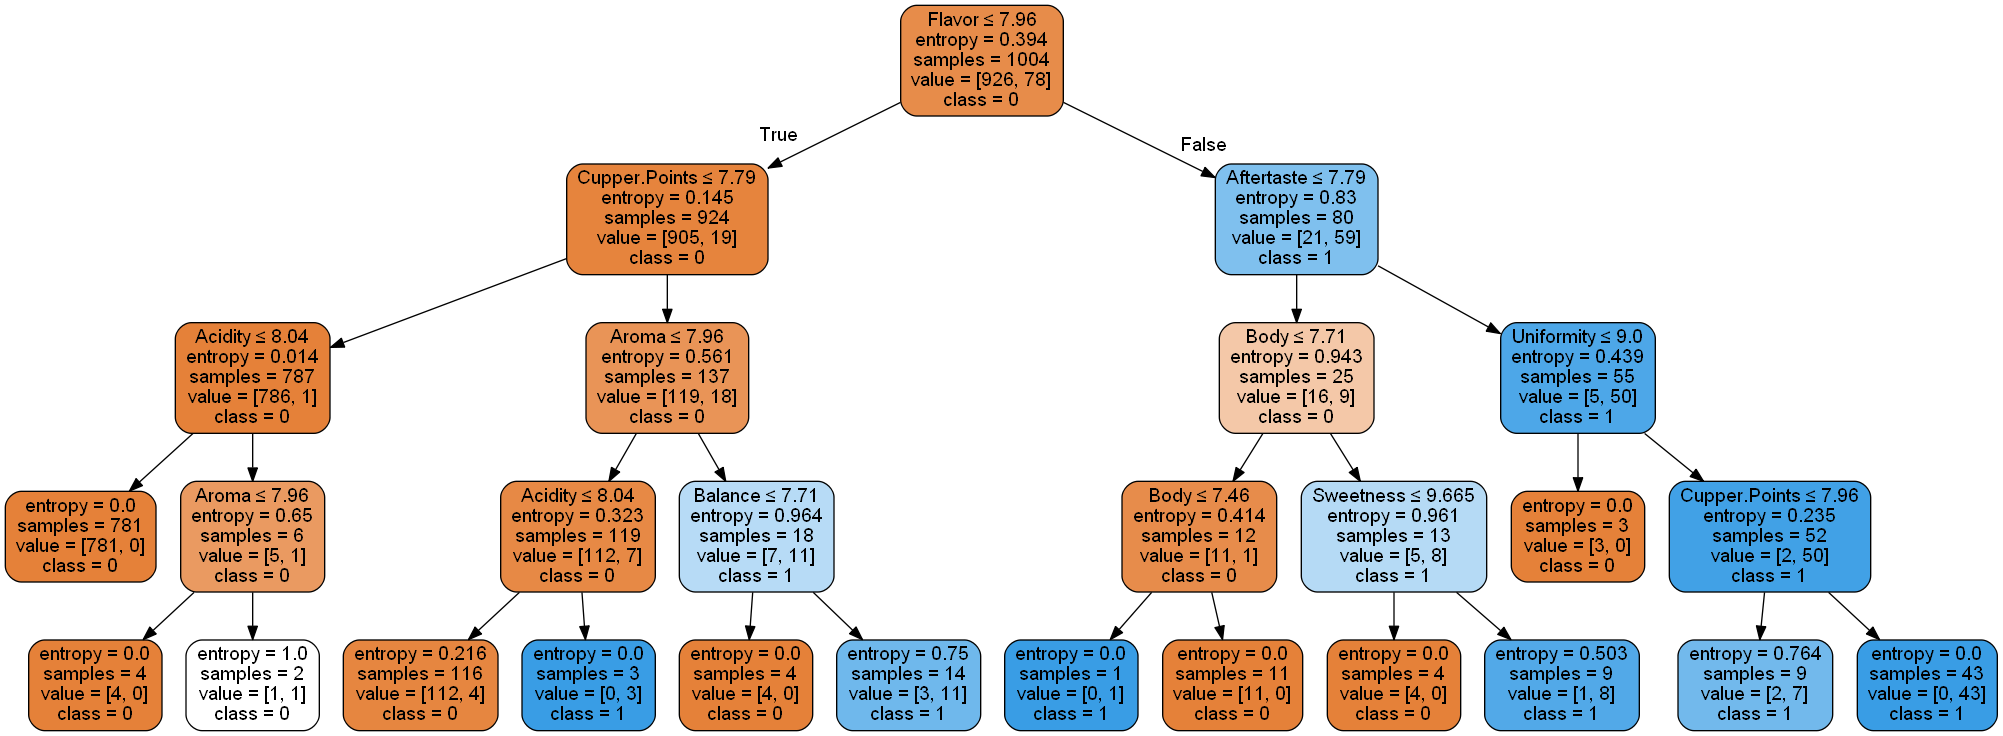

In [54]:
from sklearn.tree import export_graphviz
import pydotplus
from sklearn import tree
from IPython.display import Image
import os
os.environ['PATH'] = os.environ['PATH'] + (';c:\\Program Files (x86)\\Graphviz2.38\\bin\\') # 解決Graphviz問題

#使用 pydotplus在jupyter內生成決策樹圖
dot_tree = tree.export_graphviz(coffee_cate,out_file=None,feature_names=list(x),class_names=['0','1'],filled=True, rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_tree)
Image(graph.create_png())

# Random Forest

In [36]:
X = ddf[["Owner","Species","Aroma","Flavor","Acidity","Sweetness","Body","Aftertaste","Balance","Uniformity","Clean.Cup","Cupper.Points","Moisture"]]
Y = ddf['Pass']

In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

In [38]:
X_train.head(3)

,Owner,Species,Aroma,Flavor,Acidity,Sweetness,Body,Aftertaste,Balance,Uniformity,Clean.Cup,Cupper.Points,Moisture
652,nucoffee,1,7.58,7.50,7.75,10.00,7.50,7.33,7.50,10.00,10.00,7.42,0.00
254,doi tung development project,1,7.92,8.17,8.42,9.33,8.08,8.17,8.17,8.67,8.67,8.42,0.12
1240,juan luis alvarado romero,1,7.00,6.83,7.17,10.00,6.67,6.83,6.83,10.00,10.00,6.67,0.11


In [39]:
X_train_NoName = X_train[["Aroma","Flavor","Acidity","Sweetness","Body","Aftertaste","Balance","Uniformity","Clean.Cup","Cupper.Points","Moisture"]]
X_train_NoName.head(3)

,Aroma,Flavor,Acidity,Sweetness,Body,Aftertaste,Balance,Uniformity,Clean.Cup,Cupper.Points,Moisture
652,7.58,7.50,7.75,10.00,7.50,7.33,7.50,10.00,10.00,7.42,0.00
254,7.92,8.17,8.42,9.33,8.08,8.17,8.17,8.67,8.67,8.42,0.12
1240,7.00,6.83,7.17,10.00,6.67,6.83,6.83,10.00,10.00,6.67,0.11


In [40]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth = 3, n_estimators = 10)
rfc.fit(X_train_NoName, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [41]:
X_test_NoName = X_test[["Aroma","Flavor","Acidity","Sweetness","Body","Aftertaste","Balance","Uniformity","Clean.Cup","Cupper.Points","Moisture"]]
X_test_NoName.head(3)

,Aroma,Flavor,Acidity,Sweetness,Body,Aftertaste,Balance,Uniformity,Clean.Cup,Cupper.Points,Moisture
280,7.67,7.75,7.75,10.0,7.42,7.67,7.75,10.0,10.0,7.83,0.00
834,7.25,7.33,7.33,10.0,7.67,7.50,7.42,10.0,10.0,7.33,0.00
641,7.75,7.42,7.50,10.0,7.58,7.33,7.50,10.0,10.0,7.50,0.12


In [42]:
print('The accuracy of Random Forest Classifier on testing set:', rfc.score(X_test_NoName, Y_test))

The accuracy of Random Forest Classifier on testing set: 0.982089552238806


# XGB

In [43]:
from xgboost import XGBClassifier

In [44]:
xgbc = XGBClassifier()
xgbc.fit(X_train_NoName, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [45]:
print('The accuracy of eXtreme Gradient Boosting Classifier on testing set:', xgbc.score(X_test_NoName, y_test))

The accuracy of eXtreme Gradient Boosting Classifier on testing set: 0.8388059701492537
